In [8]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.tri as mtri

# Physical constants
L, W = 1.0, 0.5    # domain size (cm)
lambda_, mu = 5e9, 5e9  # elastic constants (Pa)
h = 1.0            # thickness (cm)
sf = 1e9           # stress scaling

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        # now outputs: u_x, u_y, E_xx, E_yy, E_xy
        self.net = nn.Sequential(
            nn.Linear(2, 128),
            nn.Softplus(beta=10),
            nn.Linear(128, 128),
            nn.Softplus(beta=10),
            nn.Linear(128, 128),
            nn.Softplus(beta=10),
            nn.Linear(128, 5)
        )

    def forward(self, x, y):
        # normalize into [-1,1]
        xi  = 2.0 * x / L
        eta = 2.0 * y / W

        raw = self.net(torch.cat([xi, eta], dim=1))
        # enforce zero displacement at x=-L/2 (Dirichlet on u_x,u_y)
        enforced = torch.zeros_like(raw)
        enforced[:,0] = (x.flatten() + L/2) * raw[:,0]  # u_x
        enforced[:,1] = (x.flatten() + L/2) * raw[:,1]  # u_y
        # strain outputs pass through directly
        enforced[:,2:] = raw[:,2:]
        return enforced

def strain_tensor(u_x, u_y, x, y):
    u_x_x = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x),
                                retain_graph=True, create_graph=True)[0]
    u_y_y = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y),
                                retain_graph=True, create_graph=True)[0]
    u_x_y = torch.autograd.grad(u_x, y, grad_outputs=torch.ones_like(u_x),
                                retain_graph=True, create_graph=True)[0]
    u_y_x = torch.autograd.grad(u_y, x, grad_outputs=torch.ones_like(u_y),
                                retain_graph=True, create_graph=True)[0]

    E_xx = u_x_x
    E_yy = u_y_y
    E_xy = 0.5*(u_x_y + u_y_x)
    return E_xx, E_yy, E_xy
    
# stress from strain
def stress_tensor(E_xx, E_yy, E_xy):
    tr = E_xx + E_yy
    s_xx = h * ((lambda_/sf) * tr + 2 * (mu/sf) * E_xx)
    s_yy = h * ((lambda_/sf) * tr + 2 * (mu/sf) * E_yy)
    s_xy = h * (2 * (mu/sf) * E_xy)
    return s_xx, s_yy, s_xy

# physics loss with FO-PINN compatibility
def physics_loss(model, x, y):
    x.requires_grad_(True)
    y.requires_grad_(True)
    out = model(x, y)
    u_x_net, u_y_net = out[:,0:1], out[:,1:2]
    E_xx_net, E_yy_net, E_xy_net = out[:,2:3], out[:,3:4], out[:,4:5]

    # compute true strain via autograd
    u_x = u_x_net; u_y = u_y_net
    u_x_x = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_y_y = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
    u_x_y = torch.autograd.grad(u_x, y, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_y_x = torch.autograd.grad(u_y, x, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
    E_xx = u_x_x
    E_yy = u_y_y
    E_xy = 0.5 * (u_x_y + u_y_x)

    # compatibility losses
    lc1 = torch.mean((E_xx_net - E_xx)**2)
    lc2 = torch.mean((E_yy_net - E_yy)**2)
    lc3 = torch.mean((E_xy_net - E_xy)**2)
    w_comp = 4.0

    # stress from network-predicted strain
    s_xx, s_yy, s_xy = stress_tensor(E_xx_net, E_yy_net, E_xy_net)

    # PDE residual (first-order derivatives)
    s_xx_x = torch.autograd.grad(s_xx, x, grad_outputs=torch.ones_like(s_xx), create_graph=True)[0]
    s_xy_y = torch.autograd.grad(s_xy, y, grad_outputs=torch.ones_like(s_xy), create_graph=True)[0]
    s_yy_y = torch.autograd.grad(s_yy, y, grad_outputs=torch.ones_like(s_yy), create_graph=True)[0]
    s_xy_x = torch.autograd.grad(s_xy, x, grad_outputs=torch.ones_like(s_xy), create_graph=True)[0]
    rx = s_xx_x + s_xy_y
    ry = s_yy_y + s_xy_x
    lpde = torch.mean(rx**2 + ry**2)

    return lpde + w_comp * (lc1 + lc2 + lc3)

# BC loss remains as penalty on u_x,u_y
def boundary_condition_loss(model, L, W):
    w_A, w_D, w_C, w_B = 1.0, 1.0, 1.0, 1.0

    # A: x=-L/2, u_x=u_y=0
    y_A = torch.linspace(-W/2, W/2, 100).reshape(-1,1)
    x_A = -L/2 * torch.ones_like(y_A)
    x_A.requires_grad_(True); y_A.requires_grad_(True)
    u_A = model(x_A, y_A)
    ux_A, uy_A = u_A[:,0:1], u_A[:,1:2]
    loss_A = torch.mean(ux_A**2 + uy_A**2)

    # D: x=+L/2, u_x=0.025L, u_y=0
    y_D = y_A.clone()
    x_D = L/2 * torch.ones_like(y_D)
    x_D.requires_grad_(True); y_D.requires_grad_(True)
    u_D = model(x_D, y_D)
    ux_D, uy_D = u_D[:,0:1], u_D[:,1:2]
    loss_D = torch.mean((ux_D - 0.025*L)**2 + uy_D**2)

    # C: y=0 symmetry ⇒ u_y=0 & σ_xy=0
    x_C = torch.linspace(-L/2, L/2, 200).reshape(-1,1)
    y_C = torch.zeros_like(x_C)
    x_C.requires_grad_(True); y_C.requires_grad_(True)
    u_C = model(x_C, y_C)
    ux_C, uy_C = u_C[:,0:1], u_C[:,1:2]
    _, _, sxy_C = stress_tensor(*strain_tensor(ux_C, uy_C, x_C, y_C))
    loss_C = torch.mean(uy_C**2) + torch.mean(sxy_C**2)

    # B: y=+W/2 traction‐free ⇒ σ_yy=0, σ_xy=0
    x_B = x_C.clone()
    y_B = W/2 * torch.ones_like(x_B)
    x_B.requires_grad_(True); y_B.requires_grad_(True)
    u_B = model(x_B, y_B)
    ux_B, uy_B = u_B[:,0:1], u_B[:,1:2]
    E_xx_B, E_yy_B, E_xy_B = strain_tensor(ux_B, uy_B, x_B, y_B)
    _, syy_B, sxy_B = stress_tensor(E_xx_B, E_yy_B, E_xy_B)
    loss_B = torch.mean(syy_B**2 + sxy_B**2)

    return (w_A*loss_A + w_D*loss_D + w_C*loss_C + w_B*loss_B)

# Training and evaluation remain unchanged

def train_pinn(model, optimizer, n_epochs, n_points, L, W):
    history = []
    w_pde, w_bc = 1.0, 50.0

    for ep in range(n_epochs):
        x = torch.rand(n_points,1)*L - L/2
        y = torch.rand(n_points,1)*W/2

        lp = physics_loss(model, x, y)
        lb = boundary_condition_loss(model, L, W)
        loss = w_pde*lp + w_bc*lb

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        history.append(loss.item())
        if ep % 500 == 0:
            print(f"Epoch {ep}, PDE: {lp.item():.3e}, BC: {lb.item():.3e}")
    return history

# rest of script (initialization, data loading, plotting) unchanged
model     = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 10000
n_points = 1000
loss_history = train_pinn(model, optimizer, n_epochs, n_points, L, W)

Epoch 0, PDE: 5.709e-01, BC: 1.735e+00
Epoch 500, PDE: 8.970e-04, BC: 1.038e-05
Epoch 1000, PDE: 3.309e-04, BC: 2.840e-06
Epoch 1500, PDE: 2.064e-04, BC: 1.748e-06
Epoch 2000, PDE: 1.596e-04, BC: 1.262e-06
Epoch 2500, PDE: 1.249e-04, BC: 9.693e-07
Epoch 3000, PDE: 1.096e-04, BC: 7.598e-07
Epoch 3500, PDE: 8.732e-05, BC: 6.570e-07
Epoch 4000, PDE: 7.501e-05, BC: 5.928e-07
Epoch 4500, PDE: 7.477e-05, BC: 6.558e-05
Epoch 5000, PDE: 6.049e-05, BC: 4.565e-07
Epoch 5500, PDE: 6.043e-05, BC: 7.554e-07
Epoch 6000, PDE: 5.660e-05, BC: 5.675e-07
Epoch 6500, PDE: 5.769e-05, BC: 3.560e-07
Epoch 7000, PDE: 5.363e-05, BC: 2.719e-05
Epoch 7500, PDE: 5.680e-05, BC: 2.858e-06
Epoch 8000, PDE: 5.182e-05, BC: 3.436e-07
Epoch 8500, PDE: 5.231e-05, BC: 3.684e-07
Epoch 9000, PDE: 9.505e-05, BC: 7.621e-05
Epoch 9500, PDE: 5.315e-05, BC: 4.321e-07


         X     Y    u_x_actual    u_y_actual  u_x_pred  u_y_pred  \
0    -0.50 -0.25  1.483633e-19  1.263433e-19  0.000000 -0.000000   
1    -0.48 -0.25  9.101041e-04  9.363998e-04  0.000250 -0.000113   
2    -0.50 -0.23 -1.530000e-20 -4.190000e-20  0.000000 -0.000000   
3    -0.48 -0.23  5.332043e-04  6.506182e-04  0.000246 -0.000105   
4    -0.50 -0.21  2.321675e-21 -6.630000e-21  0.000000 -0.000000   
...    ...   ...           ...           ...       ...       ...   
1321  0.48  0.23  2.446680e-02 -6.510000e-04  0.023701 -0.001257   
1322  0.50  0.21  2.500000e-02  3.680167e-18  0.024434 -0.000981   
1323  0.48  0.25  2.408990e-02 -9.360000e-04  0.023628 -0.001469   
1324  0.50  0.23  2.500000e-02  1.768693e-18  0.024348 -0.001189   
1325  0.50  0.25  2.500000e-02  2.080774e-17  0.024273 -0.001403   

         error_u_x     error_u_y  percent_error_u_x  percent_error_u_y  
0     1.483633e-19  1.263433e-19           0.000000           0.000000  
1     6.602681e-04  1.049655e-03     

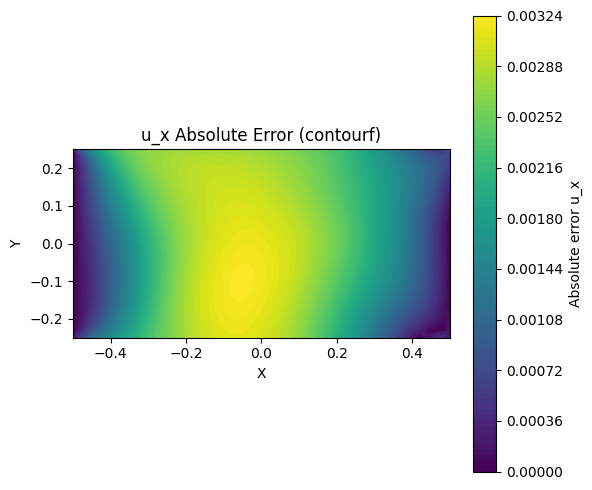

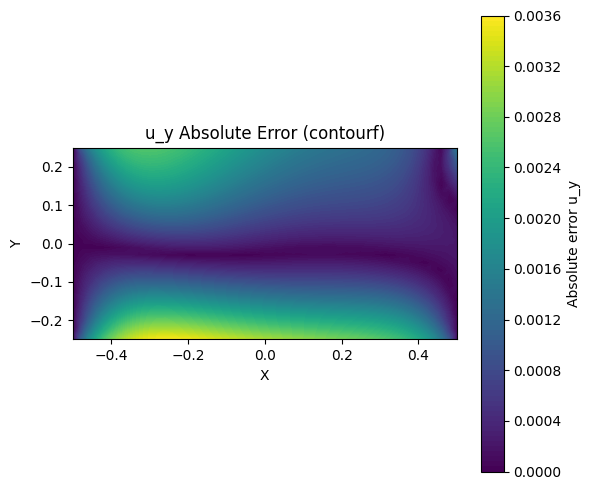

In [9]:
# read actual data
file_path       = '/Users/murat/Downloads/data.csv'
comparison_data = pd.read_csv(file_path)

x_values      = torch.tensor(comparison_data['X'].values, dtype=torch.float32).reshape(-1,1)
y_values      = torch.tensor(comparison_data['Y'].values, dtype=torch.float32).reshape(-1,1)
u_x_actual    = comparison_data['u_x_actual'].values
u_y_actual    = comparison_data['u_y_actual'].values

# predictions
model.eval()
with torch.no_grad():
    u_pred = model(x_values, y_values)
u_x_pred = u_pred[:,0].numpy()
u_y_pred = u_pred[:,1].numpy()

comparison_data['u_x_pred']        = u_x_pred
comparison_data['u_y_pred']        = u_y_pred
comparison_data['error_u_x']       = np.abs(u_x_actual - u_x_pred)
comparison_data['error_u_y']       = np.abs(u_y_actual - u_y_pred)

# percent error (safe)
comparison_data['percent_error_u_x'] = comparison_data.apply(
    lambda r: 0 if np.isclose(r.u_x_actual,0) else abs(r.u_x_actual - r.u_x_pred)/abs(r.u_x_actual)*100,
    axis=1
)
comparison_data['percent_error_u_y'] = comparison_data.apply(
    lambda r: 0 if np.isclose(r.u_y_actual,0) else abs(r.u_y_actual - r.u_y_pred)/abs(r.u_y_actual)*100,
    axis=1
)

print(comparison_data)

avg_px = comparison_data['percent_error_u_x'].mean()
avg_py = comparison_data['percent_error_u_y'].mean()
print(f"Average Percent Error for u_x: {avg_px:.2f}%")
print(f"Average Percent Error for u_y: {avg_py:.2f}%")

X = comparison_data['X'].values
Y = comparison_data['Y'].values
Ex = comparison_data['error_u_x'].values
Ey = comparison_data['error_u_y'].values

# build a Delaunay triangulation:
triang = mtri.Triangulation(X, Y)

# u_x absolute error
fig, ax = plt.subplots(figsize=(6,5))
tcf = ax.tricontourf(triang, Ex, levels=100, cmap='viridis')
fig.colorbar(tcf, ax=ax, label='Absolute error u_x')
ax.set_xlabel('X'); ax.set_ylabel('Y')
ax.set_title('u_x Absolute Error (contourf)')
ax.set_aspect('equal', 'box')
plt.tight_layout()
plt.show()

# u_y absolute error
fig, ax = plt.subplots(figsize=(6,5))
tcf = ax.tricontourf(triang, Ey, levels=100, cmap='viridis')
fig.colorbar(tcf, ax=ax, label='Absolute error u_y')
ax.set_xlabel('X'); ax.set_ylabel('Y')
ax.set_title('u_y Absolute Error (contourf)')
ax.set_aspect('equal', 'box')
plt.tight_layout()
plt.show()